In [40]:
%load_ext autoreload
#%autoreload 2

import pandas as pd
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint
from scipy.stats import norm
from assets_allocator import AssetsAllocator
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:

optimalPortfolios = pd.DataFrame(np.array([[0.6, 0.7], [0.4, 0.3]]), columns=['ACWI', 'TBSC'])
optimalPortfolios.head()

goals = pd.DataFrame({'Nazwa': ["Dom", 'Emerytura']})    
        

In [42]:
assetsAllocator = AssetsAllocator(optimalPortfolios)
assetsAllocation = assetsAllocator.expectedAllocation(goals)
print(assetsAllocation)

      Dom  Emerytura
ACWI  0.0        0.0
TBSC  0.0        0.0


In [43]:
#sheet_name='2011-2021'
acwi_tbsc = pd.read_excel('./acwi_tbsc.xlsx')
acwi_tbsc.head()

,ACWI,TBSC
0,0.020931,0.005868
1,-0.004996,0.002708
2,0.012963,0.012686
3,0.008176,0.016935
4,-0.006637,0.004393


In [44]:
means = acwi_tbsc.mean() *12
cov_table = acwi_tbsc.cov() * 12

weights = np.array([0.6, 0.4])
print(means)
print(cov_table)
print(acwi_tbsc.std()*np.sqrt(12))

ACWI    0.134085
TBSC    0.027678
dtype: float64
          ACWI      TBSC
ACWI  0.012553  0.000395
TBSC  0.000395  0.001240
ACWI    0.112039
TBSC    0.035215
dtype: float64


In [45]:
def pstd(weights, cov_matrix):
    #variance = np.transpose(weights)@cov_matrix@weights
    variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(variance)

def pmean(weights, means):
    return np.sum(weights * means)

In [46]:
std = pstd(weights=weights, cov_matrix=cov_table)
print(std)



0.07005106014425842


In [47]:
def probabilityOfRequiredReturns(weights, expectedReturn, portfolioMeanReturns, portfolioCovariance: pd.DataFrame):
    portfolioMean = pmean(weights=weights,means=portfolioMeanReturns)
    portfolioStd = pstd(weights=weights, cov_matrix=portfolioCovariance)          
    return norm.cdf(x=expectedReturn, loc=portfolioMean, scale=portfolioStd)

In [48]:
probabilityOfRequiredReturns(weights=weights,expectedReturn=0.07,portfolioMeanReturns=means,portfolioCovariance=cov_table)

0.3793328479433782

In [49]:
allocations = []

xs = (0.1 * n for n in range(11))

for n in xs:
    allocations.append(np.array([n, 1-n]))

print(allocations)

[array([0., 1.]), array([0.1, 0.9]), array([0.2, 0.8]), array([0.3, 0.7]), array([0.4, 0.6]), array([0.5, 0.5]), array([0.6, 0.4]), array([0.7, 0.3]), array([0.8, 0.2]), array([0.9, 0.1]), array([1., 0.])]


In [50]:
expectedReturn = 0.02
for n in allocations:
    p = probabilityOfRequiredReturns(n,expectedReturn=expectedReturn, portfolioMeanReturns=means, portfolioCovariance=cov_table)
    p = np.round(p,4)*-1
    print(f'Porfolio: {n}, propability: {p}')

Porfolio: [0. 1.], propability: -0.4137
Porfolio: [0.1 0.9], propability: -0.2986
Porfolio: [0.2 0.8], propability: -0.2213
Porfolio: [0.3 0.7], propability: -0.182
Porfolio: [0.4 0.6], propability: -0.1643
Porfolio: [0.5 0.5], propability: -0.1567
Porfolio: [0.6 0.4], propability: -0.1536
Porfolio: [0.7 0.3], propability: -0.1527
Porfolio: [0.8 0.2], propability: -0.1529
Porfolio: [0.9 0.1], propability: -0.1535
Porfolio: [1. 0.], propability: -0.1543


In [51]:
start_pos = [0.5,0.5]

#Says one minus the sum of all variables must be zero
constraint = NonlinearConstraint(lambda x: x.sum(), 1,1)

#Required to have non negative values
bnds = [(0,1), (0,1)]

result = minimize(probabilityOfRequiredReturns,start_pos, args=(0.07,means,cov_table), bounds=bnds, constraints=constraint)

print(result)

     fun: 0.28366705888896804
     jac: array([-0.21163855, -0.07758224])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([1.00000000e+00, 2.22044605e-16])


In [52]:
def findAssetsAllocation(requiredRateOfReturn, portfolioReturns, portfolioCov):
    result = result = minimize(
        probabilityOfRequiredReturns,
        [0.5,0.5], 
        args=(requiredRateOfReturn,portfolioReturns,portfolioCov), 
        bounds=[(0,1),(0,1)], 
        constraints=NonlinearConstraint(lambda x: x.sum(), 1,1)
        )
    return (np.round(result.fun,2), [np.round(n,1) for n in result.x])
    

In [53]:
probability, portfolio = findAssetsAllocation(0.07, means, cov_table)
row = [probability, *portfolio]
print(f'Portfolio: {portfolio}, probability: {probability}')
print(row)


Portfolio: [1.0, 0.0], probability: 0.28
[0.28, 1.0, 0.0]


In [54]:
portfolio_waights = pd.DataFrame({'RequiredReturn':[], 'Propability': [], 'Acwi': [], 'TBSC': []})

requiredReturns = [n * 0.005 for n in range(1, 41)]

for n in requiredReturns:
    probability, portfolio = findAssetsAllocation(n,means,cov_table)
    print(f'RequiredRate: {n}, Portfolio: {portfolio}, probability: {probability}')
    


RequiredRate: 0.005, Portfolio: [0.4, 0.6], probability: 0.1
RequiredRate: 0.01, Portfolio: [0.5, 0.5], probability: 0.12
RequiredRate: 0.015, Portfolio: [0.6, 0.4], probability: 0.14
RequiredRate: 0.02, Portfolio: [0.7, 0.3], probability: 0.15
RequiredRate: 0.025, Portfolio: [1.0, 0.0], probability: 0.17
RequiredRate: 0.03, Portfolio: [1.0, 0.0], probability: 0.18
RequiredRate: 0.035, Portfolio: [1.0, 0.0], probability: 0.19
RequiredRate: 0.04, Portfolio: [1.0, 0.0], probability: 0.2
RequiredRate: 0.045, Portfolio: [1.0, 0.0], probability: 0.21
RequiredRate: 0.05, Portfolio: [1.0, 0.0], probability: 0.23
RequiredRate: 0.055, Portfolio: [1.0, 0.0], probability: 0.24
RequiredRate: 0.06, Portfolio: [1.0, 0.0], probability: 0.25
RequiredRate: 0.065, Portfolio: [1.0, 0.0], probability: 0.27
RequiredRate: 0.07, Portfolio: [1.0, 0.0], probability: 0.28
RequiredRate: 0.075, Portfolio: [1.0, 0.0], probability: 0.3
RequiredRate: 0.08, Portfolio: [1.0, 0.0], probability: 0.31
RequiredRate: 0.085

In [55]:
allocations = []

xs = (0.1 * n for n in range(11))

for n in xs:
    allocations.append(np.array([n, 1-n])) 


portfolioResults = np.zeros((4,len(allocations)), np.float64)

for n in range(len(allocations)):
    mean = pmean(allocations[n],means)
    std = pstd(allocations[n], cov_table)
    allocation =  allocations[n]
    print(f'allocations: {allocation}, mean: {mean}, std: {std}')



allocations: [0. 1.], mean: 0.027678296419985458, std: 0.035215452091304555
allocations: [0.1 0.9], mean: 0.03831891835378337, std: 0.034657970508677007
allocations: [0.2 0.8], mean: 0.04895954028758129, std: 0.03771301140818877
allocations: [0.3 0.7], mean: 0.059600162221379205, std: 0.0436281674503585
allocations: [0.4 0.6], mean: 0.07024078415517712, std: 0.05142579330051563
allocations: [0.5 0.5], mean: 0.08088140608897502, std: 0.06038093154305164
allocations: [0.6 0.4], mean: 0.09152202802277294, std: 0.07005106014425844
allocations: [0.7 0.3], mean: 0.10216264995657086, std: 0.08017789356531406
allocations: [0.8 0.2], mean: 0.11280327189036878, std: 0.09060843041194146
allocations: [0.9 0.1], mean: 0.12344389382416669, std: 0.10124885264914829
allocations: [1. 0.], mean: 0.1340845157579646, std: 0.11203937754080365


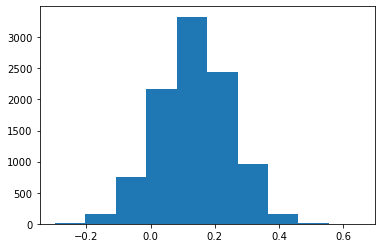

In [56]:
#weight 100,00

values = np.random.normal(0.134,0.112,10000)

plt.hist(values)
plt.show()

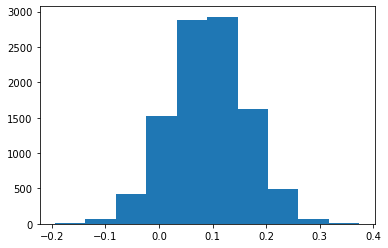

In [57]:
#weight: 60%,40%

values = np.random.normal(0.091,0.07,10000)

plt.hist(values)
plt.show()

In [58]:
def generateReturns(period, mean, std):
    returns = np.zeros(period)
    for n in range(period):
        returns[n]= np.random.normal(mean, std)
    return returns

def generatePortfolio(returns, initial,payment):
    portfolioValue = initial
    
    for r in returns:
        portfolioValue = (portfolioValue + payment)* (1+r)

    return np.round(portfolioValue,2)

def probabilityOfGoal(goal, values: np.array):
    return np.count_nonzero(values >= goal)/len(values)
    #return [np.percentile(values,25), np.percentile(values,50), np.percentile(values,50)]


def goalProbability(goal, period, initial, payment, mean, std):
    ntrials = 10000
    portfolioValues = np.zeros(ntrials)
    
    for n in range(ntrials):
      returns = generateReturns(period, mean,std)
      portfolioValues[n] = generatePortfolio(returns, initial,payment)
    
    return probabilityOfGoal(goal,portfolioValues)

In [59]:
goal = 12250
initial = 10000
payment = 0
period = 3
weights = np.array([1,0])
mean = pmean(weights,means)
std = pstd(weights, cov_matrix=cov_table)
#mean = 0.093
#std = 0.1445
probability = goalProbability(goal, period, initial, payment, mean, std)
print(probability)

0.827


In [60]:
array = np.array([[1,2,3], [4,5,6]])
array.T


array([[1, 4],
       [2, 5],
       [3, 6]])

In [61]:
mean = 0.093
std = 0.1445
expectedReturn=0.07
1- norm.cdf(x=expectedReturn, loc=mean, scale=std)


0.5632323532849406

In [62]:
mean = 0.9417
std = 0.4675
expectedReturn=0.9672
1- norm.cdf(x=expectedReturn, loc=mean, scale=std)

0.478250297488931

In [63]:
mean = 0.093
std = 0.1445
weights = np.array([1,0])
#mean = pmean(weights,means)
#std = pstd(weights, cov_table)
expectedReturn=0.07
returns = np.zeros(10000)
t = 10

def randCumulative():
    cumulative = 1
    for n in range(t):
        cumulative = cumulative * (1+ np.random.normal(mean,std))
    return cumulative ** (1/t) - 1

for n in range (10000):
    returns[n] = randCumulative()

probabilityOfGoal(expectedReturn,returns)


0.6203

In [64]:
print(generateReturns(period, mean, std))
print(std)

[ 0.13751191 -0.02574407  0.04925425]
0.1445


In [65]:
t =10
r = np.log(500000/400000)*(1/t)
std = 0.1
ppf = norm.ppf(0.8)
mean = 0.5*std**2+ (ppf/(t**(1/2)))*std+r
print(mean)



0.053928755383930785


In [66]:
t =10
#r = np.log(500000/400000)*(1/t)
r = 0.07
std = 0.1445
ppf = norm.ppf(0.6149)
mean = 0.5*std**2+ (ppf/(t**(1/2)))*std+r
print(mean)


0.09378821647533797


In [67]:
np.log(100)
#np.e**7.01775867
#np.e**4.605170185988092

4.605170185988092

In [68]:
meanMin = 0.0526
stdMin = 0.0374
meanMax = 0.0886
stdMax = 0.1954
#Wmax = 1834
W0 = 100
T = 6
iMax = 20
def Wmax(t,meanMax,stdMin,stdMax):
    return W0*np.e**((meanMax-(stdMin**2/2))*t + 3*stdMax*np.sqrt(t))
def Wmin(t, meanMin, stdMin, stdMax):
    return W0*np.e**((meanMin-stdMax**2/2)*t - 3*stdMax*np.sqrt(t))
def Wi(i, imax, Wmin, Wmax):
    return np.log(Wmin)+((i-1)/(imax-1))*(np.log(Wmax) - np.log(Wmin))

for t in range(1,T):
    max = Wmax(t, meanMax, stdMin,stdMax)
    min = Wmin(t, meanMin, stdMin, stdMax)
    W = np.zeros(iMax)
    for i in range (0, iMax):
        W[i] = Wi(i,iMax,min,max)
    print(f"t: {t}, min: {min}, max: {max}, W: {W}")



t: 1, min: 57.53995672215052, max: 196.22673580916378, W: [3.98791165 4.05247961 4.11704756 4.18161552 4.24618348 4.31075144
 4.3753194  4.43988735 4.50445531 4.56902327 4.63359123 4.69815918
 4.76272714 4.8272951  4.89186306 4.95643102 5.02099897 5.08556693
 5.15013489 5.21470285]
t: 2, min: 46.67352258680458, max: 273.1397082868874, W: [3.75018723 3.84317704 3.93616685 4.02915665 4.12214646 4.21513627
 4.30812608 4.40111589 4.4941057  4.58709551 4.68008532 4.77307513
 4.86606494 4.95905475 5.05204456 5.14503437 5.23802418 5.33101399
 5.4240038  5.51699361]
t: 3, min: 40.05967681138664, max: 359.31528324592813, W: [3.57490553 3.69037026 3.805835   3.92129973 4.03676447 4.1522292
 4.26769394 4.38315867 4.49862341 4.61408814 4.72955288 4.84501761
 4.96048235 5.07594708 5.19141182 5.30687655 5.42234129 5.53780602
 5.65327076 5.76873549]
t: 4, min: 35.40340018631632, max: 459.0562107123408, W: [3.43194656 3.56680787 3.70166917 3.83653048 3.97139178 4.10625309
 4.24111439 4.3759757  4.5108

In [69]:
max = Wmax(t, meanMax, stdMin,stdMax)
min = Wmin(t, meanMin, stdMin, stdMax)
logW0 = 4.605170185988092
W = np.zeros(iMax)
for i in range (0, iMax):
    W[i] = Wi(i,iMax,min,max)
We = W-logW0
E = We[We>=0].min()
print(E)
W = W-E



0.07508914498783525


In [70]:
''' logMax = 7.50683674
Wmax = np.e**logMax
Wmax = Wmax*np.e**-E
Wmax '''

' logMax = 7.50683674\nWmax = np.e**logMax\nWmax = Wmax*np.e**-E\nWmax '

In [71]:
Wmax = Wi(476,476,Wmin(11, meanMin, stdMin, stdMax),Wmax(11, meanMax, stdMin, stdMax))
Wmax = Wmax - 0.0018323897958030244
np.e**Wmax

1834.3584270143306

In [72]:
from goal_optimasier import generateGrid
meanMin = 0.0526
stdMin = 0.0374
meanMax = 0.0886
stdMax = 0.1954
W0 = 100
T = 3
iMax = 10

grid = generateGrid(W0,T,iMax, meanMin, stdMin, meanMax, stdMax)

print(grid)

#TODO
# dodawać 1 do iMax w metodzie, grid to iMax + 1
# zrobić assertację, do całej tablicy
#dodać grid z chashflowami

[[ 50.58320071  57.97023288  66.43604702  76.13818548  87.25719769
  100.         114.60372628 131.34014078 150.52069544 172.50232581]
 [ 45.60069263  55.49177024  67.52828491  82.17559547 100.
  121.6906302  148.08609478 180.20690197 219.29491467 266.86136365]
 [ 37.71789481  48.12941508  61.41489625  78.36765675 100.
  127.60366221 162.82694609 207.77314627 265.12614373 338.31066886]]


In [73]:
def prob1(W0, W1, mean, std, h):
    return (1/(std*np.sqrt(h)))*(np.log(W1/W0)-((mean-(std**2)/2)*h))
def prob2(W0, W1, mean, std, h):
    return norm.pdf((np.log(W1/W0)-(mean-0.5*std**2)*h)/(std*np.sqrt(h)))
mean = 0.10
std = 0.01
h = 1
W0 = 100
WI1 = 110
q = prob2(W0, WI1, mean, std, h)
#norm.pdf(q)
q

0.35823066284185373

In [74]:
from goal_optimasier import calculateTransitionPropabilities

W0 = 100
meanMin = 0.0526
stdMin = 0.0374
meanMax = 0.0886
stdMax = 0.1954
iMax = 10
W1 = generateGrid(W0,1,iMax,meanMin,stdMin,meanMax,stdMax)[0]

portfolios = [[meanMin,stdMin],[meanMax, stdMax]]

probabilities = np.zeros((2,iMax))

for i, portfolio in enumerate(portfolios):
    probabilities[i] = calculateTransitionPropabilities(portfolio, W0,W1, 1)

values = np.multiply(W1, probabilities)
print(np.round(W1,1))
print(np.round(probabilities,2))
print(np.round(values,1))
print(values.sum(1))
max = values.sum(1).max()
port = np.where(values.sum(1) == max)
port[0]
    

[ 50.6  58.   66.4  76.1  87.3 100.  114.6 131.3 150.5 172.5]
[[0.   0.   0.   0.   0.   0.83 0.17 0.   0.   0.  ]
 [0.   0.   0.01 0.06 0.16 0.26 0.26 0.16 0.06 0.01]]
[[ 0.   0.   0.   0.   0.  83.  19.5  0.   0.   0. ]
 [ 0.   0.1  0.9  4.6 14.  26.2 30.2 21.3  9.3  2.5]]
[102.48587057 109.05939079]


array([1], dtype=int64)

In [75]:
from goal_optimasier import reachedGoal

W = np.array([150,130,110,100,90,70,50])

reachedGoal(W, 130)


array([1, 1, 0, 0, 0, 0, 0])

In [76]:
from goal_optimasier import calculateTransitionPropabilities

def calculateTransitionPropabilitiesForAllPorfolios(portfolioMeasures, WT, WT1, h=1):
    i = len(WT1)
    probabilities = np.zeros((i,len(portfolioMeasures),i),np.float64)
    for i in range(i):
        probabilities[i] = np.apply_along_axis(calculateTransitionPropabilities,1,portfolioMeasures, W0=WT, W1=WT1[i])
    return probabilities

W0 = 100
meanMin = 0.0726
stdMin = 0.0574
meanMax = 0.0886
stdMax = 0.1954
iMax = 5
WT = generateGrid(W0,1,iMax,meanMin,stdMin,meanMax,stdMax)[0]
WT1 = generateGrid(W0,2,iMax,meanMin,stdMin,meanMax,stdMax)[1]

portfolios = [[meanMin, stdMin], [meanMax, stdMax]]
%timeit
propabilities = calculateTransitionPropabilitiesForAllPorfolios(portfolios,WT, WT1),
indaces = np.array([[[1,1,1,0,0]]])
chosen = np.take_along_axis(probabilities,indaces,1)
chosen = chosen[:,0,:]
np.round(probabilities,3)
np.round(chosen,3)

ValueError: `indices` and `arr` must have the same number of dimensions

In [77]:
def get_strategies(V):
    sums = V.sum(2)
    maxes = np.amax(sums,1)
    porfolio_ids = np.argmax(sums,1)
    return porfolio_ids, maxes

V = np.array([[[0,0.2,0.4, 0.5], [0,0,0.3, 0.5]],[[0,0.3,0.5, 0.6], [0,0,0.4, 0.6,]],[[0,0.3,0.5, 0.6], [0,0,0.4, 0.6,]], [[0,0.3,0.4, 0.6], [0,0.3,0.6, 0.8,]]])

"result = [1.1, 1.4, 1.4, 1.7]"
''' ([[1.1, 0.8],
       [1.4, 1. ],
       [1.4, 1. ], '''

get_strategies(V)


(array([0, 0, 0, 1], dtype=int64), array([1.1, 1.4, 1.4, 1.7]))

In [79]:
from goal_optimasier import reachedGoal
from numba import jit


def generateGlidePath(W0, goal, T, portfolioMeasures):
    iMax = 475
    grid = generateGrid(W0,T,iMax,meanMin,stdMin,meanMax,stdMax)
    strategies = np.zeros((T,iMax))
    V = np.zeros((T,iMax))
    probabilitiesT = np.zeros((T,iMax,iMax))

    indexOf100 = np.where(grid[1]==100)

    V[T-1] = reachedGoal(grid[T-1],goal)   

    for t in range(T-2,0,-1):
        probabilities = calculateTransitionPropabilitiesForAllPorfolios(portfolioMeasures,grid[t],grid[t+1])
        VT = V[t+1] * probabilities        
        porfolios_ids, VT_max = get_strategies(VT)
        V[t] = VT_max  
        strategies[t] = porfolios_ids  
        chosen_propabilities = np.take_along_axis(probabilities,np.expand_dims(porfolios_ids,axis=(0,1)),1)
        probabilitiesT[t] = chosen_propabilities[:,0,:]

    return strategies, probabilitiesT

W0 = 30000
meanMin = 0.0526
stdMin = 0.0374
meanMax = 0.0886
stdMax = 0.1954


#portfolios = [[meanMin, stdMin], [meanMax, stdMax]]

''' portfolios = [[0.05258386, 0.03704926],
       [0.05515672, 0.03960988],
       [0.05772681, 0.04625568],
       [0.06029967, 0.05555016],
       [0.06286483, 0.06637403],
       [0.06545148, 0.07813246],
       [0.06801664, 0.09041086],
       [0.07059443, 0.103057  ],
       [0.07315959, 0.11592848],
       [0.07573245, 0.12898073],
       [0.07830254, 0.14213997],
       [0.0808754 , 0.15540374],
       [0.08344549, 0.16872224],
       [0.08601835, 0.18210899],
       [0.08858351, 0.19552512]]  ''' #us stock, bonds, int stock

''' portfolios = [[0.00510286, 0.00872209],
       [0.00644207, 0.01231416],
       [0.00708567, 0.01456807],
       [0.00772926, 0.01698759],
       [0.00837286, 0.01951121],
       [0.00901645, 0.02210329],
       [0.00966005, 0.02474234],
       [0.01030364, 0.02741479],
       [0.01094724, 0.03011175],
       [0.01159083, 0.03282718]] ''' #ACWI_TBSP

portfolios = [[0.04672458, 0.03677211],
       [0.06510331, 0.04488049],
       [0.07397588, 0.05298884],
       [0.08157529, 0.06109721],
       [0.0886005 , 0.06920556],
       [0.09530129, 0.07731393],
       [0.1017962 , 0.08542229],
       [0.10704432, 0.09353065],
       [0.11115349, 0.10163901],
       [0.11418045, 0.10974737],
       [0.11648888, 0.11785573],
       [0.11849021, 0.1259641 ],
       [0.12031556, 0.13407246],
       [0.12202592, 0.14218083],
       [0.12365509, 0.15028918]] #complicates

porfolioStrategy, probabilitiesI = generateGlidePath(W0,60,8,portfolios)

#np.round(probabilitiesI,3)
porfolioStrategy[1,205]



4.0

In [ ]:
inputPropabilities = probabilitiesI
sums = inputPropabilities.sum(1)
cumulativeProbabilities = np.ones((10,475))
cumulativeProbabilities[0] = sums[1]
T=8
for t in range(2,T):
    cumulativeProbabilities[t-1] = cumulativeProbabilities[t-2]*sums[t]
    
print(cumulativeProbabilities[1,205]) 



0.6895217966334115


0.769